# Introduction

**Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines**

https://www.drivendata.org/competitions/66/flu-shot-learning/data/

# Importing modules and data

In [ ]:
!pip install datatable
!pip install missingno
!pip install pycaret
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
en-core-web-sm 3.4.1 requires spa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.20.0-cp38-cp38-manylinux2010_x86_64.whl (15.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.8 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
import numpy as np
import pandas as pd
import datatable as dt
import missingno as msno
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import itertools

In [ ]:
training_set_labels_path = '/content/drive/MyDrive/Python/training_set_labels.csv'
training_set_features_path = '/content/drive/MyDrive/Python/training_set_features.csv'
test_set_features_path = '/content/drive/MyDrive/Python/test_set_features.csv'
submission_format_path = '/content/drive/MyDrive/Python/submission_format.csv'

In [ ]:
training_set_features = dt.fread(training_set_features_path)
training_set_features = training_set_features.to_pandas()

training_set_labels = dt.fread(training_set_labels_path)
training_set_labels = training_set_labels.to_pandas()

test_set_features = dt.fread(test_set_features_path)
test_set_features = test_set_features.to_pandas()

submission_format = dt.fread(submission_format_path)
submission_format = submission_format.to_pandas()

features_sets = [training_set_features, test_set_features]

# Initial data exploration and cleaning

## Checking and replacing missing values.

In [ ]:
training_set_features.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                          0
race                               0
sex                                0
income_poverty                     0
m

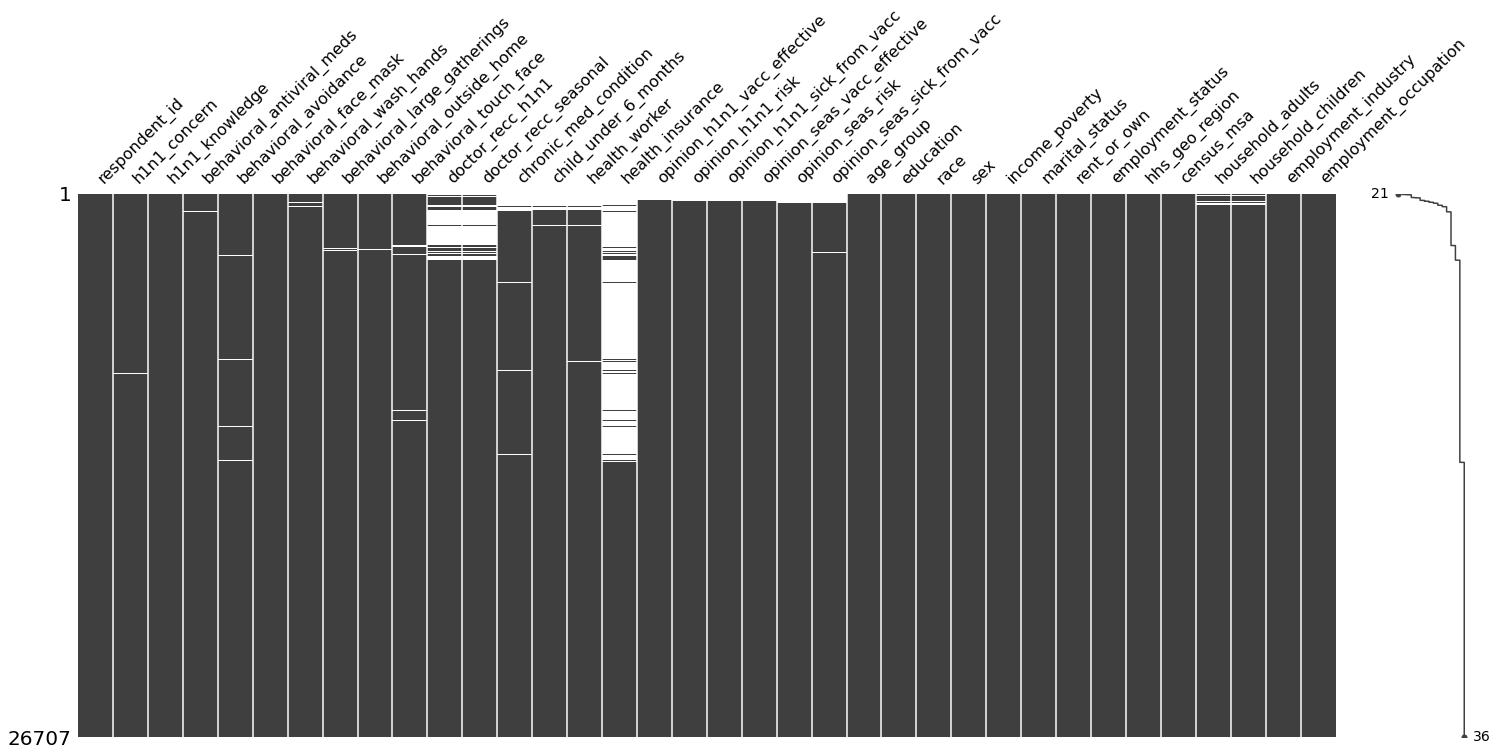

In [ ]:
msno.matrix(training_set_features, sort='ascending')

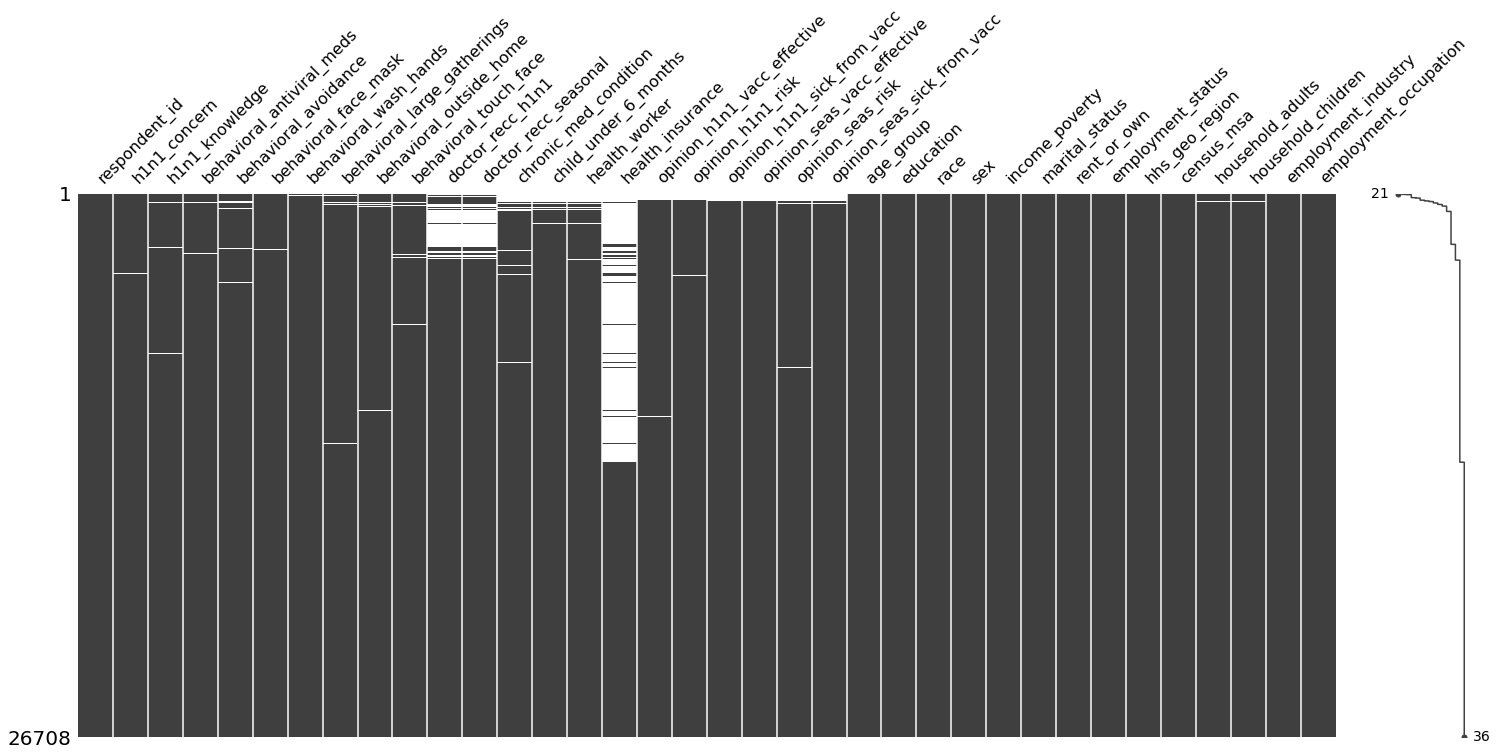

In [ ]:
msno.matrix(test_set_features, sort='ascending')

Health insurance information is missing greatly and might be caused by respondents reluctance to share that information. Missing values will be filled with 0.

Both doctor recommendations are also missing (and correlated) due to reluctance of respondents to share medical information but might be crucial for the modeling. Missing values will be filled with 0.

All other features have some missing values in both train and test tables but cannot be dropped because of expected prediction labels. Missing values will be filled with 0.

In [ ]:
for table in features_sets:
  table.fillna(value=0, inplace=True)

In [ ]:
training_set_features.isna().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

## Replacing boolean with -1/1

In [ ]:
for table in features_sets:
  table.replace(True, 1, inplace=True)
  table.replace(False, -1, inplace=True)

In [ ]:
training_set_labels.replace(True, 1, inplace=True)
training_set_labels.replace(False, -1, inplace=True)

## Checking unique values

In [ ]:
for col in training_set_features:
  print(str(training_set_features[col].nunique())+" unique values in "+col +".")

26707 unique values in respondent_id.
4 unique values in h1n1_concern.
3 unique values in h1n1_knowledge.
2 unique values in behavioral_antiviral_meds.
2 unique values in behavioral_avoidance.
2 unique values in behavioral_face_mask.
2 unique values in behavioral_wash_hands.
2 unique values in behavioral_large_gatherings.
2 unique values in behavioral_outside_home.
2 unique values in behavioral_touch_face.
2 unique values in doctor_recc_h1n1.
2 unique values in doctor_recc_seasonal.
2 unique values in chronic_med_condition.
2 unique values in child_under_6_months.
2 unique values in health_worker.
2 unique values in health_insurance.
6 unique values in opinion_h1n1_vacc_effective.
6 unique values in opinion_h1n1_risk.
6 unique values in opinion_h1n1_sick_from_vacc.
6 unique values in opinion_seas_vacc_effective.
6 unique values in opinion_seas_risk.
6 unique values in opinion_seas_sick_from_vacc.
5 unique values in age_group.
5 unique values in education.
4 unique values in race.
2 uni

In [ ]:
for table in features_sets:
  
  for col in table.columns:

    unique_values_in_table = list(table[col].unique())

    if len(unique_values_in_table) > 2:
      
      print("Unique values in " + col + ":")
      print(unique_values_in_table)

    else:

      pass

Unique values in respondent_id:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 21

## Converting low cardinality string values in dataframes to numeric

Defining dictionaries of all features but: race, sex, employment_industry and employment_occupation.

In [ ]:
values_dict = {
    '18 - 34 Years' : 1,
    '35 - 44 Years' : 2,
    '45 - 54 Years' : 3,
    '55 - 64 Years' : 4,
    '65+ Years' : 5,
    '< 12 Years' : 1,
    '12 Years' : 2,
    'Some College' : 3,
    'College Graduate' : 4,
    '' : 0,
    'Below Poverty' : 1,
    '<= $75,000, Above Poverty' : 2,
    '> $75,000' : 3,
    'Not Married' : -1,
    'Married' : 1,
    'Rent' : 1,
    'Own' : 2,
    'Employed' : 2,
    'Not in Labor Force' : 1,
    'Unemployed' : -1,
    'MSA, Principle City' : 2,
    'MSA, Not Principle  City' : 1,
    'Non-MSA' : 0
}

In [ ]:
training_set_features.replace(values_dict, inplace=True)
test_set_features.replace(values_dict, inplace=True)
None

## One hot enconding race and sex

In [ ]:
from sklearn.preprocessing import OneHotEncoder

for table in features_sets:

  ohe_race = OneHotEncoder(dtype='int')
  transformed_race = ohe_race.fit_transform(table[['race']])

  table[ohe_race.categories_[0]] = transformed_race.toarray()

  ohe_sex = OneHotEncoder(dtype='int')
  transformed_sex = ohe_sex.fit_transform(table[['sex']])

  table[ohe_sex.categories_[0]] = transformed_sex.toarray()

In [ ]:
training_set_features = training_set_features.drop(['race', 'sex'], axis=1)
test_set_features = test_set_features.drop(['race', 'sex'], axis=1)

## Encoding employment_industry and employment_occupation based on occurence

In [ ]:
employment_industry_frequency = training_set_features['employment_industry'].value_counts().rank().to_dict()
training_set_features['employment_industry'].replace(employment_industry_frequency, inplace=True)
test_set_features['employment_industry'].replace(employment_industry_frequency, inplace=True)

In [ ]:
employment_occupation_frequency = training_set_features['employment_occupation'].value_counts().rank().to_dict()
training_set_features['employment_occupation'].replace(employment_occupation_frequency, inplace=True)
test_set_features['employment_occupation'].replace(employment_occupation_frequency, inplace=True)

In [ ]:
hhs_geo_region_frequency = training_set_features['hhs_geo_region'].value_counts().rank().to_dict()
training_set_features['hhs_geo_region'].replace(hhs_geo_region_frequency, inplace=True)
test_set_features['hhs_geo_region'].replace(hhs_geo_region_frequency, inplace=True)

## Correlations, heatmap and feature selection

In [ ]:
training_set_full = training_set_labels.merge(training_set_features, on='respondent_id')
training_set_full_corr = training_set_full.corr()
training_set_full_corr = abs(training_set_full_corr)
training_set_full_corr['sum'] = (training_set_full_corr['h1n1_vaccine'] + training_set_full_corr['seasonal_vaccine']) / 2
training_set_full_corr = training_set_full_corr.sort_values('sum', ascending=False)

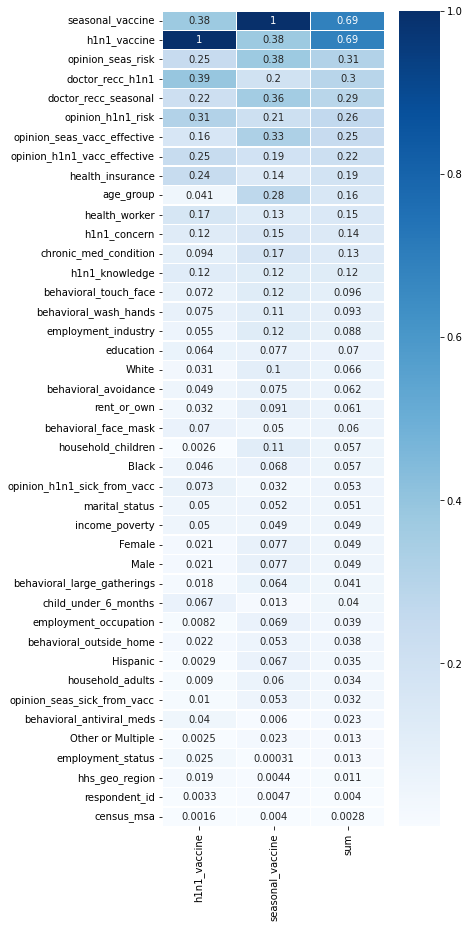

In [ ]:
fig, ax = plt.subplots(figsize=(5,15))

training_set_full_corr_h1n1 = training_set_full_corr[['h1n1_vaccine','seasonal_vaccine','sum']]
sns.heatmap(training_set_full_corr_h1n1, linewidths=.5, ax=ax, cmap="Blues", annot=True)

In [ ]:
training_set_full_corr_h1n1 = training_set_full_corr[training_set_full_corr.h1n1_vaccine > .1]
training_set_full_corr_h1n1_cols = set(training_set_full_corr_h1n1.index)

training_set_full_corr_seas = training_set_full_corr[training_set_full_corr.seasonal_vaccine > .1]
training_set_full_corr_seas_cols = set(training_set_full_corr_seas.index)

Feature engineering data from correlated data

In [ ]:
for pair in itertools.product(training_set_full_corr_h1n1_cols, repeat=2):
  new_feature_name = f"{pair[0]}_x_{pair[1]}"
  new_feature_value = training_set_full[pair[0]] * training_set_full[pair[1]]
  training_set_full[new_feature_name] = new_feature_value

<ipython-input-25-00cc11dc6215>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  training_set_full[new_feature_name] = new_feature_value


In [ ]:
for pair in itertools.product(training_set_full_corr_seas_cols, repeat=2):
  new_feature_name = f"{pair[0]}_x_{pair[1]}"
  new_feature_value = training_set_full[pair[0]] * training_set_full[pair[1]]
  training_set_full[new_feature_name] = new_feature_value

<ipython-input-26-5609de1477b8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  training_set_full[new_feature_name] = new_feature_value


In [ ]:
len(training_set_full.columns)

403

In [ ]:
training_set_full = training_set_full.T.drop_duplicates().T

In [ ]:
len(training_set_full.columns)

223

In [ ]:
training_set_full_corr2 = training_set_full.corr()
training_set_full_corr2 = abs(training_set_full_corr2)
training_set_full_corr2['sum'] = (training_set_full_corr2['h1n1_vaccine'] + training_set_full_corr2['seasonal_vaccine']) / 2
training_set_full_corr2 = training_set_full_corr2.sort_values('sum', ascending=False)

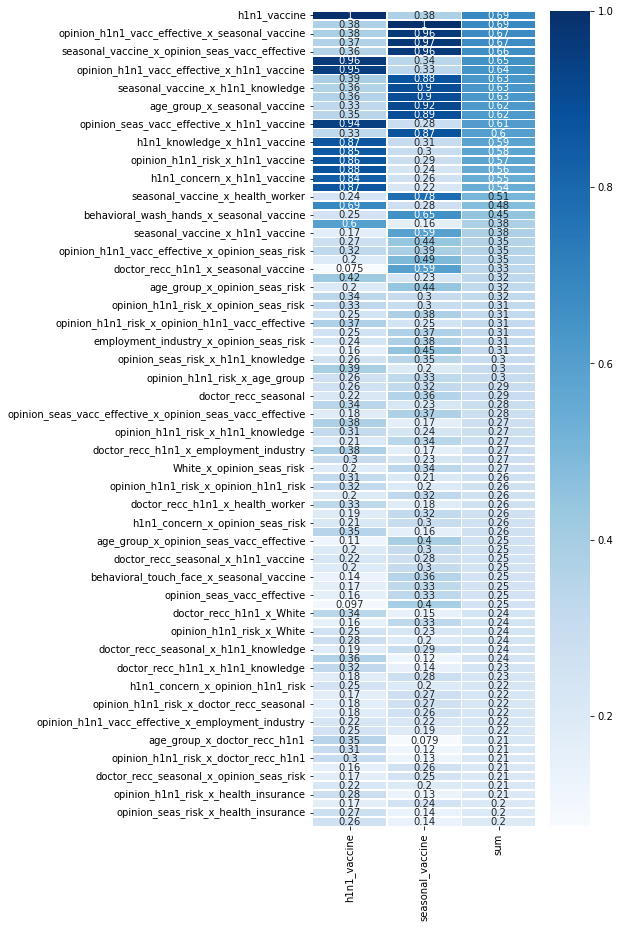

In [ ]:
fig, ax = plt.subplots(figsize=(5,15))

training_set_full_corr2_h1n1 = training_set_full_corr2[['h1n1_vaccine','seasonal_vaccine','sum']]
sns.heatmap(training_set_full_corr2_h1n1[training_set_full_corr2_h1n1['sum'] > .2], linewidths=.5, ax=ax, cmap="Blues", annot=True)

Leaving only features with correlation over 0.2

In [ ]:
features_to_keep = training_set_full_corr2_h1n1[training_set_full_corr2_h1n1['sum'] > .2].index

training_set_full = training_set_full[features_to_keep]

In [ ]:
training_set_full

h1n1_vaccine  seasonal_vaccine  \
0              -1.0              -1.0   
1              -1.0               1.0   
2              -1.0              -1.0   
3              -1.0               1.0   
4              -1.0              -1.0   
...             ...               ...   
26702          -1.0              -1.0   
26703          -1.0              -1.0   
26704          -1.0               1.0   
26705          -1.0              -1.0   
26706          -1.0              -1.0   

       opinion_h1n1_vacc_effective_x_seasonal_vaccine  \
0                                                -3.0   
1                                                 5.0   
2                                                -3.0   
3                                                 3.0   
4                                                -3.0   
...                                               ...   
26702                                            -3.0   
26703                                            -4.0   
26704                                             4.0   
26705                                            -3.0   
26706                                            -5.0   

       employment_industry_x_seasonal_vaccine  \
0                                       -22.0   
1                                        18.0   
2                                       -12.0   
3                                        22.0   
4                                       -20.0   
...                                       ...   
26702                                   -22.0   
26703                                   -21.0   
26704                                    22.0   
26705                                   -21.0   
26706                                   -22.0   

       seasonal_vaccine_x_opinion_seas_vacc_effective  \
0                                                -2.0   
1                                                 4.0   
2                                                -4.0   
3                                                 5.0   
4                                                -3.0   
...                                               ...   
26702                                            -5.0   
26703                                            -5.0   
26704                                             5.0   
26705                                            -2.0   
26706                                            -5.0   

       h1n1_vaccine_x_employment_industry  \
0                                   -22.0   
1                                   -18.0   
2                                   -12.0   
3                                   -22.0   
4                                   -20.0   
...                                   ...   
26702                               -22.0   
26703                               -21.0   
26704                               -22.0   
26705                               -21.0   
26706                               -22.0   

       opinion_h1n1_vacc_effective_x_h1n1_vaccine  \
0                                            -3.0   
1                                            -5.0   
2                                            -3.0   
3                                            -3.0   
4                                            -3.0   
...                                           ...   
26702                                        -3.0   
26703                                        -4.0   
26704                                        -4.0   
26705                                        -3.0   
26706                                        -5.0   

       opinion_h1n1_risk_x_seasonal_vaccine  \
0                                      -1.0   
1                                       4.0   
2                                      -1.0   
3                                       3.0   
4                                      -3.0   
...                                     ...   
26702                                  -1.0   
2

# Checking class imbalance for H1N1

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


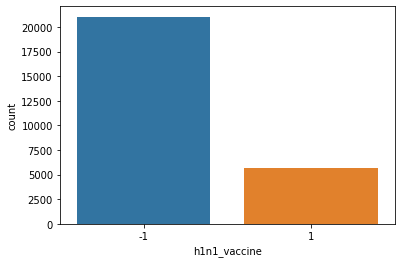

In [ ]:
sns.countplot(training_set_labels['h1n1_vaccine'])

In [ ]:
training_set_full = training_set_labels.merge(training_set_features,
                                              on='respondent_id')

training_set_full_h1n1 = training_set_full.drop('seasonal_vaccine', axis=1)
training_set_full_seas = training_set_full.drop('h1n1_vaccine', axis=1)

In [ ]:
'''
training_set_full_h1n1.drop(labels=training_set_full_corr_h1n1_cols, axis=1, inplace=True)
print(len(training_set_full_h1n1.columns))

training_set_full_seas.drop(labels=training_set_full_corr_seas_cols, axis=1, inplace=True)
print(len(training_set_full_seas.columns))
'''

'\ntraining_set_full_h1n1.drop(labels=training_set_full_corr_h1n1_cols, axis=1, inplace=True)\nprint(len(training_set_full_h1n1.columns))\n\ntraining_set_full_seas.drop(labels=training_set_full_corr_seas_cols, axis=1, inplace=True)\nprint(len(training_set_full_seas.columns))\n'

# Building and predicting model for H1N1

In [ ]:
from pycaret.classification import *

In [ ]:
features_ignored = [
    'respondent_id'
]

In [ ]:
classification_setup = setup(data = training_set_full_h1n1,
                             target = 'h1n1_vaccine',
                             ignore_features = features_ignored,
                             fix_imbalance = True,
                             silent = True,
                             #polynomial_features = True,
                             normalize = False,
                             session_id=42) 

Description             Value
0                               session_id                42
1                                   Target      h1n1_vaccine
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data       (26707, 41)
5                           Missing Values             False
6                         Numeric Features                13
7                     Categorical Features                26
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (18694, 57)
12                    Transformed Test Set        (8013, 57)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              1bda
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance              True
59                    Fix Imbalance Method             SMOTE

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['respondent_id'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='h1n1_vaccine',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numeri...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers

In [ ]:
best_model = compare_models(sort = 'AUC')

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.8547  0.8635  0.5141  0.7233   
gbc          Gradient Boosting Classifier    0.8529  0.8624  0.5196  0.7116   
rf               Random Forest Classifier    0.8490  0.8539  0.4626  0.7288   
ada                  Ada Boost Classifier    0.8424  0.8506  0.5701  0.6483   
et                 Extra Trees Classifier    0.8470  0.8481  0.4676  0.7152   
lda          Linear Discriminant Analysis    0.7960  0.8479  0.7399  0.5148   
lr                    Logistic Regression    0.7908  0.8477  0.7477  0.5063   
nb                            Naive Bayes    0.6653  0.7438  0.6965  0.3545   
knn                K Neighbors Classifier    0.6219  0.7218  0.7462  0.3291   
dt               Decision Tree Classifier    0.7677  0.6692  0.4975  0.4582   
qda       Quadratic Discriminant Analysis    0.2129  0.5000  1.0000  0.2129   
dummy                    Dummy Classifier    0.7871  0.5000  0.0000  0.0000   
svm                   SVM - Linear Kernel    0.8279  0.0000  0.5613  0.6375   
ridge                    Ridge Classifier    0.7960  0.0000  0.7402  0.5148   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.6004  0.5149  0.5264     1.885  
gbc       0.6001  0.5128  0.5226     9.302  
rf        0.5655  0.4797  0.4981     4.414  
ada       0.6061  0.5082  0.5102     2.398  
et        0.5650  0.4771  0.4932     4.899  
lda       0.6069  0.4752  0.4896     0.908  
lr        0.6034  0.4685  0.4852     2.557  
nb        0.4698  0.2614  0.2934     0.686  
knn       0.4567  0.2288  0.2741     5.892  
dt        0.4768  0.3280  0.3285     0.892  
qda       0.3511  0.0000  0.0000     0.709  
dummy     0.0000  0.0000  0.0000     0.598  
svm       0.5692  0.4668  0.4832     1.913  
ridge     0.6070  0.4752  0.4898     0.634

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
the_best_model = create_model(best_model)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8519  0.8512  0.5025  0.7168  0.5908  0.5038  0.5156
1       0.8642  0.8700  0.5678  0.7338  0.6402  0.5582  0.5651
2       0.8417  0.8627  0.4573  0.6947  0.5515  0.4603  0.4752
3       0.8567  0.8647  0.5578  0.7070  0.6236  0.5366  0.5424
4       0.8620  0.8709  0.5427  0.7397  0.6261  0.5439  0.5537
5       0.8486  0.8513  0.4724  0.7203  0.5706  0.4834  0.4993
6       0.8539  0.8658  0.4925  0.7341  0.5895  0.5048  0.5197
7       0.8598  0.8705  0.5402  0.7313  0.6214  0.5377  0.5470
8       0.8604  0.8687  0.5201  0.7473  0.6133  0.5314  0.5444
9       0.8480  0.8596  0.4874  0.7080  0.5774  0.4886  0.5012
Mean    0.8547  0.8635  0.5141  0.7233  0.6004  0.5149  0.5264
Std     0.0068  0.0070  0.0355  0.0158  0.0272  0.0298  0.0272

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
the_best_model_tuned = tune_model(the_best_model,
                                  round = 4,
                                  n_iter = 50,
                                  choose_better = True,
                                  optimize = 'AUC')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8465  0.8515  0.4950  0.6961  0.5786  0.4880  0.4986
1       0.8620  0.8760  0.5452  0.7381  0.6272  0.5449  0.5543
2       0.8417  0.8641  0.4523  0.6977  0.5488  0.4581  0.4739
3       0.8620  0.8648  0.5628  0.7273  0.6346  0.5512  0.5581
4       0.8625  0.8730  0.5276  0.7527  0.6204  0.5396  0.5523
5       0.8480  0.8561  0.4648  0.7227  0.5657  0.4789  0.4960
6       0.8545  0.8664  0.5000  0.7316  0.5940  0.5092  0.5229
7       0.8566  0.8695  0.5251  0.7257  0.6093  0.5243  0.5346
8       0.8534  0.8723  0.5000  0.7263  0.5923  0.5066  0.5197
9       0.8534  0.8597  0.5025  0.7246  0.5935  0.5076  0.5203
Mean    0.8541  0.8653  0.5075  0.7243  0.5964  0.5108  0.5230
Std     0.0067  0.0074  0.0322  0.0160  0.0259  0.0286  0.0264

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 4
INFO:logs:LGBMClassifier(bagging_fraction=0.8, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.2,
               n_estimators=250, n_jobs=-1, num_leaves=20, objective=None,
               random_state=42, reg_alpha=0.7, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
the_best_model_boosted = ensemble_model(the_best_model_tuned, method = 'Boosting', choose_better = True)

Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                               
0       0.7872  0.5     0.0    0.0  0.0    0.0  0.0
1       0.7872  0.5     0.0    0.0  0.0    0.0  0.0
2       0.7872  0.5     0.0    0.0  0.0    0.0  0.0
3       0.7872  0.5     0.0    0.0  0.0    0.0  0.0
4       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
5       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
6       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
7       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
8       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
9       0.7871  0.5     0.0    0.0  0.0    0.0  0.0
Mean    0.7871  0.5     0.0    0.0  0.0    0.0  0.0
Std     0.0001  0.0     0.0    0.0  0.0    0.0  0.0

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 5
INFO:logs:LGBMClassifier(bagging_fraction=0.8, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.2,
               n_estimators=250, n_jobs=-1, num_leaves=20, objective=None,
               random_state=42, reg_alpha=0.7, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:ensemble_model() succesfully completed......................................


In [ ]:
the_best_model_bagged = ensemble_model(the_best_model_boosted, method = 'Bagging', choose_better = True)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8465  0.8534  0.4925  0.6975  0.5773  0.4869  0.4980
1       0.8620  0.8724  0.5503  0.7349  0.6293  0.5467  0.5553
2       0.8412  0.8652  0.4397  0.7028  0.5410  0.4510  0.4692
3       0.8583  0.8670  0.5578  0.7138  0.6262  0.5404  0.5467
4       0.8593  0.8744  0.5352  0.7320  0.6183  0.5346  0.5444
5       0.8486  0.8555  0.4749  0.7186  0.5719  0.4845  0.4999
6       0.8571  0.8680  0.5126  0.7365  0.6044  0.5207  0.5334
7       0.8571  0.8713  0.5226  0.7298  0.6091  0.5246  0.5355
8       0.8577  0.8724  0.5075  0.7426  0.6030  0.5200  0.5340
9       0.8502  0.8618  0.4975  0.7122  0.5858  0.4978  0.5098
Mean    0.8538  0.8661  0.5090  0.7221  0.5966  0.5107  0.5226
Std     0.0064  0.0069  0.0337  0.0145  0.0262  0.0285  0.0259

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 6
INFO:logs:LGBMClassifier(bagging_fraction=0.8, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.2,
               n_estimators=250, n_jobs=-1, num_leaves=20, objective=None,
               random_state=42, reg_alpha=0.7, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:ensemble_model() succesfully completed......................................


In [ ]:
the_best_model_calibrated = calibrate_model(the_best_model_bagged)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8385  0.8480  0.2889  0.8582  0.4323  0.3642  0.4381
1       0.8417  0.8718  0.3090  0.8542  0.4539  0.3842  0.4526
2       0.8257  0.8621  0.2286  0.8273  0.3583  0.2931  0.3753
3       0.8492  0.8612  0.3467  0.8625  0.4946  0.4244  0.4855
4       0.8406  0.8699  0.2814  0.9032  0.4291  0.3649  0.4495
5       0.8341  0.8555  0.2613  0.8667  0.4015  0.3360  0.4183
6       0.8336  0.8616  0.2789  0.8222  0.4165  0.3460  0.4153
7       0.8422  0.8695  0.3065  0.8652  0.4527  0.3841  0.4551
8       0.8416  0.8706  0.2889  0.8984  0.4373  0.3722  0.4540
9       0.8422  0.8608  0.3040  0.8705  0.4507  0.3826  0.4553
Mean    0.8389  0.8631  0.2894  0.8628  0.4327  0.3652  0.4399
Std     0.0061  0.0072  0.0297  0.0245  0.0344  0.0331  0.0287

INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 7
INFO:logs:CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                     bagging_freq=6,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=61,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.2,
  

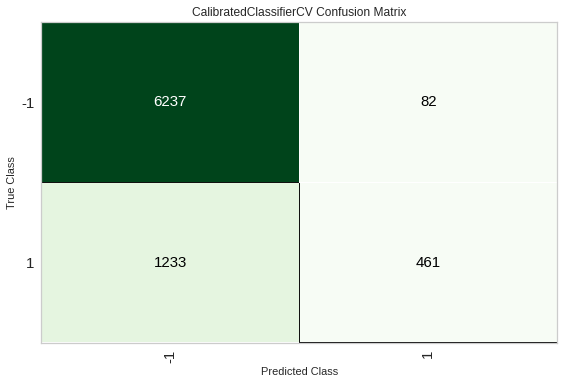

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(the_best_model_calibrated, plot = 'confusion_matrix')

In [ ]:
plot_model(the_best_model_calibrated, plot = 'feature')

INFO:logs:Initializing plot_model()
INFO:logs:plot_model(fold=None, use_train_data=False, verbose=True, is_in_evaluate=False, display=None, display_format=None, estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                     bagging_freq=6,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=61,
                                                     min_child_weight=0.001,
                   

TypeError: ignored

In [ ]:
predict_model(the_best_model_calibrated)

Model  Accuracy     AUC  Recall  Prec.      F1  \
0  Light Gradient Boosting Machine    0.8359  0.8634  0.2721  0.849  0.4122   

    Kappa    MCC  
0  0.3449  0.421

h1n1_concern  h1n1_knowledge  opinion_h1n1_vacc_effective  \
0              2.0             1.0                          0.0   
1              3.0             0.0                          0.0   
2              1.0             1.0                          4.0   
3              2.0             2.0                          5.0   
4              1.0             2.0                          4.0   
...            ...             ...                          ...   
8008           2.0             1.0                          5.0   
8009           1.0             2.0                          4.0   
8010           0.0             0.0                          1.0   
8011           3.0             1.0                          3.0   
8012           3.0             2.0                          4.0   

      opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  \
0                   0.0                          0.0   
1                   0.0                          0.0   
2                   2.0                          2.0   
3                   2.0                          2.0   
4                   2.0                          2.0   
...                 ...                          ...   
8008                1.0                          2.0   
8009                1.0                          1.0   
8010                1.0                          1.0   
8011                1.0                          1.0   
8012                2.0                          4.0   

      opinion_seas_vacc_effective  opinion_seas_risk  \
0                             0.0                0.0   
1                             0.0                0.0   
2                             4.0                4.0   
3                             4.0                2.0   
4                             4.0                1.0   
...                           ...                ...   
8008                          5.0                2.0   
8009                          5.0                1.0   
8010                          1.0                1.0   
8011                          4.0                1.0   
8012                          5.0                4.0   

      opinion_seas_sick_from_vacc  hhs_geo_region  household_adults  ...  \
0                             0.0             2.0               0.0  ...   
1                             0.0             9.0               1.0  ...   
2                             1.0             2.0               0.0  ...   
3                             1.0             5.0               1.0  ...   
4                             2.0             3.0               1.0  ...   
...                           ...             ...               ...  ...   
8008                          2.0             9.0               0.0  ...   
8009                          1.0             5.0               1.0  ...   
8010                          1.0             2.0               2.0  ...   
8011                          1.0             8.0               1.0  ...   
8012                          1.0             8.0               1.0  ...   

      census_msa_0  census_msa_1  census_msa_2  Black_0  Hispanic_0  \
0              0.0           0.0           1.0      1.0         1.0   
1              0.0           0.0           1.0      1.0         1.0   
2              0.0           1.0           0.0      1.0         1.0   
3              1.0           0.0           0.0      1.0         1.0   
4              0.0           0.0           1.0      1.0         1.0   
...            ...           ...           ...      ...         ...   
8008           0.0           0.0           1.0      1.0         1.0   
8009           0.0           1.0           0.0      1.0         1.0   
8010           0.0           0.0           1.0      1.0         1.0   
8011           0.0           0.0           1.0      0.0         1.0   
8012           0.0           0.0           1.0      1.0         0.0   

      Other or Multiple_0  White_0  h1n1_vaccine  Label   Score  
0                     1

In [ ]:
the_best_model_final = finalize_model(the_best_model_calibrated)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                     bagging_freq=6,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=61,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.2,
                                          

In [ ]:
predict_model(the_best_model_final)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                     bagging_freq=6,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=61,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.2,
                                            

Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Light Gradient Boosting Machine    0.8409  0.9025  0.2727  0.9149  0.4202   

    Kappa     MCC  
0  0.3578  0.4468

h1n1_concern  h1n1_knowledge  opinion_h1n1_vacc_effective  \
0              2.0             1.0                          0.0   
1              3.0             0.0                          0.0   
2              1.0             1.0                          4.0   
3              2.0             2.0                          5.0   
4              1.0             2.0                          4.0   
...            ...             ...                          ...   
8008           2.0             1.0                          5.0   
8009           1.0             2.0                          4.0   
8010           0.0             0.0                          1.0   
8011           3.0             1.0                          3.0   
8012           3.0             2.0                          4.0   

      opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  \
0                   0.0                          0.0   
1                   0.0                          0.0   
2                   2.0                          2.0   
3                   2.0                          2.0   
4                   2.0                          2.0   
...                 ...                          ...   
8008                1.0                          2.0   
8009                1.0                          1.0   
8010                1.0                          1.0   
8011                1.0                          1.0   
8012                2.0                          4.0   

      opinion_seas_vacc_effective  opinion_seas_risk  \
0                             0.0                0.0   
1                             0.0                0.0   
2                             4.0                4.0   
3                             4.0                2.0   
4                             4.0                1.0   
...                           ...                ...   
8008                          5.0                2.0   
8009                          5.0                1.0   
8010                          1.0                1.0   
8011                          4.0                1.0   
8012                          5.0                4.0   

      opinion_seas_sick_from_vacc  hhs_geo_region  household_adults  ...  \
0                             0.0             2.0               0.0  ...   
1                             0.0             9.0               1.0  ...   
2                             1.0             2.0               0.0  ...   
3                             1.0             5.0               1.0  ...   
4                             2.0             3.0               1.0  ...   
...                           ...             ...               ...  ...   
8008                          2.0             9.0               0.0  ...   
8009                          1.0             5.0               1.0  ...   
8010                          1.0             2.0               2.0  ...   
8011                          1.0             8.0               1.0  ...   
8012                          1.0             8.0               1.0  ...   

      census_msa_0  census_msa_1  census_msa_2  Black_0  Hispanic_0  \
0              0.0           0.0           1.0      1.0         1.0   
1              0.0           0.0           1.0      1.0         1.0   
2              0.0           1.0           0.0      1.0         1.0   
3              1.0           0.0           0.0      1.0         1.0   
4              0.0           0.0           1.0      1.0         1.0   
...            ...           ...           ...      ...         ...   
8008           0.0           0.0           1.0      1.0         1.0   
8009           0.0           1.0           0.0      1.0         1.0   
8010           0.0           0.0           1.0      1.0         1.0   
8011           0.0           0.0           1.0      0.0         1.0   
8012           0.0           0.0           1.0      1.0         0.0   

      Other or Multiple_0  White_0  h1n1_vaccine  Label   Score  
0                     1

In [ ]:
predictions_h1n1 = predict_model(the_best_model_final, data=test_set_features)
predictions_h1n1.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                     bagging_freq=6,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=61,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.2,
                                            

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0          26707           2.0             2.0                         -1   
1          26708           1.0             1.0                         -1   
2          26709           2.0             2.0                         -1   
3          26710           1.0             1.0                         -1   
4          26711           3.0             1.0                          1   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                     1                    -1                      1   
1                    -1                    -1                     -1   
2                    -1                     1                      1   
3                    -1                    -1                     -1   
4                     1                    -1                      1   

   behavioral_large_gatherings  behavioral_outside_home  \
0                            1                       -1   
1                           -1                       -1   
2                            1                        1   
3                           -1                       -1   
4                            1                        1   

   behavioral_touch_face  ...  employment_industry  employment_occupation  \
0                      1  ...                 17.0                   18.0   
1                     -1  ...                 17.0                   16.0   
2                      1  ...                  8.0                    1.0   
3                     -1  ...                 22.0                   24.0   
4                      1  ...                 21.0                   22.0   

   Black  Hispanic  Other or Multiple  White  Female  Male  Label   Score  
0      0         1                  0      0       1     0     -1  0.0805  
1      0         0                  0      1       0     1     -1  0.0611  
2      0         0                  0      1       0     1     -1  0.0985  
3      0         0                  0      1       1     0     -1  0.4330  
4      1         0                  0      0       1     0     -1  0.1169  

[5 rows x 42 columns]

# Checking class imbalance for seasonal

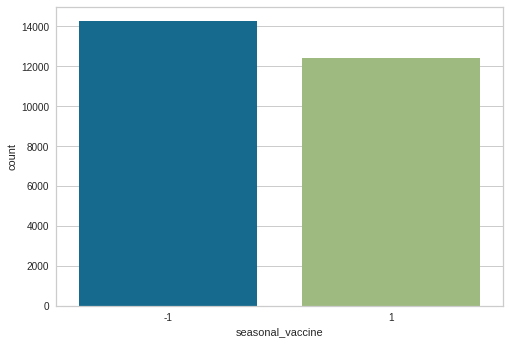

In [ ]:
sns.countplot(training_set_labels['seasonal_vaccine'])

# Building and predicting model for seasonal

In [ ]:
classification_setup_seasonal = setup(data = training_set_full_seas,
                             target = 'seasonal_vaccine',
                             ignore_features = features_ignored,
                             fix_imbalance = True,
                             silent = True,
                             #polynomial_features = True,
                             normalize = False,
                             session_id=42) 

Description             Value
0                               session_id                42
1                                   Target  seasonal_vaccine
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data       (26707, 41)
5                           Missing Values             False
6                         Numeric Features                13
7                     Categorical Features                26
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (18694, 57)
12                    Transformed Test Set        (8013, 57)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              6e4f
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance              True
59                    Fix Imbalance Method             SMOTE

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['respondent_id'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='seasonal_vaccine',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_nu...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers

In [ ]:
best_model_seas = compare_models(sort = 'AUC')

Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.7850  0.8596  0.7621  0.7755   
lightgbm  Light Gradient Boosting Machine    0.7850  0.8589  0.7599  0.7767   
ada                  Ada Boost Classifier    0.7801  0.8540  0.7519  0.7730   
rf               Random Forest Classifier    0.7742  0.8493  0.7437  0.7676   
lr                    Logistic Regression    0.7708  0.8442  0.7594  0.7538   
lda          Linear Discriminant Analysis    0.7710  0.8442  0.7525  0.7576   
et                 Extra Trees Classifier    0.7680  0.8429  0.7343  0.7623   
nb                            Naive Bayes    0.7038  0.7746  0.7515  0.6623   
knn                K Neighbors Classifier    0.6989  0.7611  0.7367  0.6605   
dt               Decision Tree Classifier    0.6828  0.6818  0.6650  0.6606   
qda       Quadratic Discriminant Analysis    0.4688  0.5000  1.0000  0.4688   
dummy                    Dummy Classifier    0.5312  0.5000  0.0000  0.0000   
svm                   SVM - Linear Kernel    0.6849  0.0000  0.7515  0.7063   
ridge                    Ridge Classifier    0.7710  0.0000  0.7524  0.7576   

              F1   Kappa     MCC  TT (Sec)  
gbc       0.7687  0.5678  0.5680     6.579  
lightgbm  0.7681  0.5677  0.5679     3.951  
ada       0.7623  0.5578  0.5580     4.184  
rf        0.7554  0.5458  0.5461     5.615  
lr        0.7565  0.5401  0.5402     4.146  
lda       0.7550  0.5401  0.5402     3.442  
et        0.7479  0.5332  0.5336     6.121  
nb        0.7040  0.4099  0.4132     3.225  
knn       0.6965  0.3996  0.4020     8.228  
dt        0.6628  0.3634  0.3635     3.410  
qda       0.6384  0.0000  0.0000     4.483  
dummy     0.0000  0.0000  0.0000     4.412  
svm       0.6865  0.3772  0.4274     4.006  
ridge     0.7549  0.5400  0.5401     3.217

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
the_best_model_seas = create_model(best_model_seas)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7898  0.8632  0.7526  0.7895  0.7706  0.5769  0.5775
1       0.7807  0.8468  0.7583  0.7706  0.7644  0.5594  0.5595
2       0.7706  0.8463  0.7571  0.7545  0.7558  0.5395  0.5395
3       0.7984  0.8731  0.7754  0.7907  0.7830  0.5948  0.5949
4       0.7908  0.8621  0.7660  0.7830  0.7744  0.5794  0.5795
5       0.7715  0.8470  0.7374  0.7663  0.7516  0.5403  0.5406
6       0.7833  0.8623  0.7557  0.7761  0.7658  0.5642  0.5644
7       0.7871  0.8623  0.7648  0.7773  0.7710  0.5720  0.5721
8       0.7785  0.8599  0.7740  0.7584  0.7661  0.5558  0.5559
9       0.7988  0.8734  0.7797  0.7887  0.7842  0.5958  0.5958
Mean    0.7850  0.8596  0.7621  0.7755  0.7687  0.5678  0.5680
Std     0.0094  0.0095  0.0119  0.0122  0.0099  0.0188  0.0188

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
the_best_model_seas_tuned = tune_model(the_best_model_seas,
                                  round = 4,
                                  n_iter = 50,
                                  choose_better = True,
                                  optimize = 'AUC')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7898  0.8642  0.7571  0.7867  0.7716  0.5771  0.5775
1       0.7791  0.8485  0.7514  0.7717  0.7614  0.5559  0.5561
2       0.7642  0.8455  0.7446  0.7506  0.7476  0.5263  0.5263
3       0.7952  0.8732  0.7742  0.7859  0.7800  0.5884  0.5885
4       0.7913  0.8622  0.7660  0.7839  0.7748  0.5805  0.5806
5       0.7715  0.8475  0.7283  0.7715  0.7493  0.5398  0.5405
6       0.7849  0.8618  0.7420  0.7869  0.7638  0.5667  0.5675
7       0.7924  0.8657  0.7626  0.7877  0.7749  0.5824  0.5826
8       0.7817  0.8607  0.7705  0.7653  0.7679  0.5619  0.5619
9       0.8026  0.8753  0.7820  0.7937  0.7878  0.6032  0.6033
Mean    0.7853  0.8605  0.7579  0.7784  0.7679  0.5682  0.5685
Std     0.0109  0.0098  0.0156  0.0126  0.0121  0.0220  0.0219

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 4
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=270,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
the_best_model_seas_boosted = ensemble_model(the_best_model_seas_tuned, method = 'Boosting', choose_better = True)

Accuracy  AUC  Recall   Prec.      F1  Kappa  MCC
Fold                                                   
0       0.4690  0.5     1.0  0.4690  0.6385    0.0  0.0
1       0.4690  0.5     1.0  0.4690  0.6385    0.0  0.0
2       0.4690  0.5     1.0  0.4690  0.6385    0.0  0.0
3       0.4690  0.5     1.0  0.4690  0.6385    0.0  0.0
4       0.5313  0.5     0.0  0.0000  0.0000    0.0  0.0
5       0.5313  0.5     0.0  0.0000  0.0000    0.0  0.0
6       0.5313  0.5     0.0  0.0000  0.0000    0.0  0.0
7       0.5313  0.5     0.0  0.0000  0.0000    0.0  0.0
8       0.5313  0.5     0.0  0.0000  0.0000    0.0  0.0
9       0.4687  0.5     1.0  0.4687  0.6383    0.0  0.0
Mean    0.5001  0.5     0.5  0.2345  0.3192    0.0  0.0
Std     0.0312  0.0     0.5  0.2345  0.3192    0.0  0.0

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 5
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=270,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:ensemble_model() succesfully completed......................................


In [ ]:
the_best_model_seas_bagged = ensemble_model(the_best_model_seas_boosted, method = 'Bagging', choose_better = True)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7920  0.8649  0.7583  0.7898  0.7737  0.5814  0.5818
1       0.7807  0.8487  0.7571  0.7712  0.7641  0.5593  0.5594
2       0.7620  0.8472  0.7446  0.7471  0.7459  0.5221  0.5221
3       0.7979  0.8750  0.7674  0.7946  0.7807  0.5933  0.5937
4       0.7961  0.8627  0.7763  0.7861  0.7812  0.5904  0.5904
5       0.7694  0.8484  0.7317  0.7658  0.7484  0.5358  0.5362
6       0.7860  0.8653  0.7489  0.7847  0.7664  0.5691  0.5696
7       0.7881  0.8665  0.7648  0.7791  0.7719  0.5741  0.5742
8       0.7796  0.8613  0.7671  0.7636  0.7654  0.5575  0.5575
9       0.7994  0.8745  0.7797  0.7896  0.7846  0.5968  0.5969
Mean    0.7851  0.8614  0.7596  0.7772  0.7682  0.5680  0.5682
Std     0.0117  0.0097  0.0140  0.0142  0.0125  0.0235  0.0235

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 6
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=270,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:ensemble_model() succesfully completed......................................


In [ ]:
the_best_model_seas_calibrated = calibrate_model(the_best_model_seas_bagged)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7920  0.8654  0.7754  0.7798  0.7776  0.5822  0.5822
1       0.7749  0.8485  0.7628  0.7585  0.7607  0.5481  0.5482
2       0.7663  0.8465  0.7605  0.7461  0.7532  0.5313  0.5314
3       0.7947  0.8751  0.7822  0.7804  0.7813  0.5878  0.5878
4       0.7924  0.8627  0.7865  0.7742  0.7803  0.5836  0.5836
5       0.7721  0.8486  0.7477  0.7616  0.7546  0.5419  0.5419
6       0.7833  0.8647  0.7671  0.7698  0.7684  0.5648  0.5648
7       0.7908  0.8661  0.7785  0.7759  0.7772  0.5800  0.5800
8       0.7812  0.8615  0.7911  0.7541  0.7721  0.5619  0.5625
9       0.7967  0.8749  0.7922  0.7780  0.7851  0.5922  0.5923
Mean    0.7844  0.8614  0.7744  0.7678  0.7711  0.5674  0.5675
Std     0.0100  0.0098  0.0138  0.0114  0.0108  0.0201  0.0201

INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 7
INFO:logs:CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.05,
                                                                 loss='deviance',
                                                                 max_depth=6,
                                                                 max_features='sqrt',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.3,
                                                                 min_impurity_split=None,
                                       

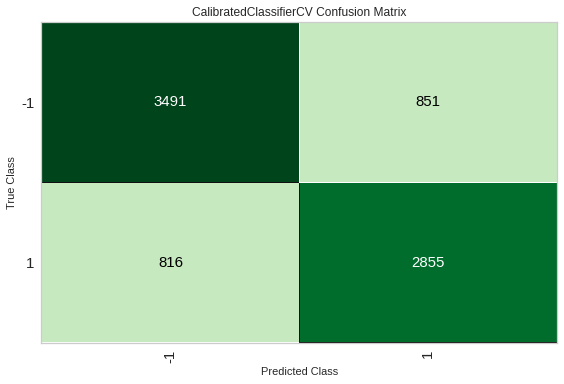

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(the_best_model_seas_calibrated, plot = 'confusion_matrix')

In [ ]:
plot_model(the_best_model_seas_calibrated, plot = 'feature')

In [ ]:
predict_model(the_best_model_seas_calibrated)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.05,
                                                                 loss='deviance',
                                                                 max_depth=6,
                                                                 max_features='sqrt',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.3,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf

Model  Accuracy     AUC  Recall   Prec.     F1  \
0  Gradient Boosting Classifier     0.792  0.8655  0.7777  0.7704  0.774   

    Kappa     MCC  
0  0.5813  0.5813

h1n1_concern  h1n1_knowledge  opinion_h1n1_vacc_effective  \
0              2.0             1.0                          0.0   
1              3.0             0.0                          0.0   
2              1.0             1.0                          4.0   
3              2.0             2.0                          5.0   
4              1.0             2.0                          4.0   
...            ...             ...                          ...   
8008           2.0             1.0                          5.0   
8009           1.0             2.0                          4.0   
8010           0.0             0.0                          1.0   
8011           3.0             1.0                          3.0   
8012           3.0             2.0                          4.0   

      opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  \
0                   0.0                          0.0   
1                   0.0                          0.0   
2                   2.0                          2.0   
3                   2.0                          2.0   
4                   2.0                          2.0   
...                 ...                          ...   
8008                1.0                          2.0   
8009                1.0                          1.0   
8010                1.0                          1.0   
8011                1.0                          1.0   
8012                2.0                          4.0   

      opinion_seas_vacc_effective  opinion_seas_risk  \
0                             0.0                0.0   
1                             0.0                0.0   
2                             4.0                4.0   
3                             4.0                2.0   
4                             4.0                1.0   
...                           ...                ...   
8008                          5.0                2.0   
8009                          5.0                1.0   
8010                          1.0                1.0   
8011                          4.0                1.0   
8012                          5.0                4.0   

      opinion_seas_sick_from_vacc  hhs_geo_region  household_adults  ...  \
0                             0.0             2.0               0.0  ...   
1                             0.0             9.0               1.0  ...   
2                             1.0             2.0               0.0  ...   
3                             1.0             5.0               1.0  ...   
4                             2.0             3.0               1.0  ...   
...                           ...             ...               ...  ...   
8008                          2.0             9.0               0.0  ...   
8009                          1.0             5.0               1.0  ...   
8010                          1.0             2.0               2.0  ...   
8011                          1.0             8.0               1.0  ...   
8012                          1.0             8.0               1.0  ...   

      census_msa_0  census_msa_1  census_msa_2  Black_0  Hispanic_0  \
0              0.0           0.0           1.0      1.0         1.0   
1              0.0           0.0           1.0      1.0         1.0   
2              0.0           1.0           0.0      1.0         1.0   
3              1.0           0.0           0.0      1.0         1.0   
4              0.0           0.0           1.0      1.0         1.0   
...            ...           ...           ...      ...         ...   
8008           0.0           0.0           1.0      1.0         1.0   
8009           0.0           1.0           0.0      1.0         1.0   
8010           0.0           0.0           1.0      1.0         1.0   
8011           0.0           0.0           1.0      0.0         1.0   
8012           0.0           0.0           1.0      1.0         0.0   

      Other or Multiple_0  White_0  seasonal_vaccine  Label   Score  
0                  

In [ ]:
the_best_model_seas_final = finalize_model(the_best_model_seas_calibrated)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.05,
                                                                 loss='deviance',
                                                                 max_depth=6,
                                                                 max_features='sqrt',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.3,
                                                                 min_impurity_split=None,
                                                                 min_samples_le

In [ ]:
predict_model(the_best_model_seas_final)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.05,
                                                                 loss='deviance',
                                                                 max_depth=6,
                                                                 max_features='sqrt',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.3,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf

Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Gradient Boosting Classifier    0.8113  0.8887  0.8001  0.7906  0.7953   

    Kappa     MCC  
0  0.6203  0.6203

h1n1_concern  h1n1_knowledge  opinion_h1n1_vacc_effective  \
0              2.0             1.0                          0.0   
1              3.0             0.0                          0.0   
2              1.0             1.0                          4.0   
3              2.0             2.0                          5.0   
4              1.0             2.0                          4.0   
...            ...             ...                          ...   
8008           2.0             1.0                          5.0   
8009           1.0             2.0                          4.0   
8010           0.0             0.0                          1.0   
8011           3.0             1.0                          3.0   
8012           3.0             2.0                          4.0   

      opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  \
0                   0.0                          0.0   
1                   0.0                          0.0   
2                   2.0                          2.0   
3                   2.0                          2.0   
4                   2.0                          2.0   
...                 ...                          ...   
8008                1.0                          2.0   
8009                1.0                          1.0   
8010                1.0                          1.0   
8011                1.0                          1.0   
8012                2.0                          4.0   

      opinion_seas_vacc_effective  opinion_seas_risk  \
0                             0.0                0.0   
1                             0.0                0.0   
2                             4.0                4.0   
3                             4.0                2.0   
4                             4.0                1.0   
...                           ...                ...   
8008                          5.0                2.0   
8009                          5.0                1.0   
8010                          1.0                1.0   
8011                          4.0                1.0   
8012                          5.0                4.0   

      opinion_seas_sick_from_vacc  hhs_geo_region  household_adults  ...  \
0                             0.0             2.0               0.0  ...   
1                             0.0             9.0               1.0  ...   
2                             1.0             2.0               0.0  ...   
3                             1.0             5.0               1.0  ...   
4                             2.0             3.0               1.0  ...   
...                           ...             ...               ...  ...   
8008                          2.0             9.0               0.0  ...   
8009                          1.0             5.0               1.0  ...   
8010                          1.0             2.0               2.0  ...   
8011                          1.0             8.0               1.0  ...   
8012                          1.0             8.0               1.0  ...   

      census_msa_0  census_msa_1  census_msa_2  Black_0  Hispanic_0  \
0              0.0           0.0           1.0      1.0         1.0   
1              0.0           0.0           1.0      1.0         1.0   
2              0.0           1.0           0.0      1.0         1.0   
3              1.0           0.0           0.0      1.0         1.0   
4              0.0           0.0           1.0      1.0         1.0   
...            ...           ...           ...      ...         ...   
8008           0.0           0.0           1.0      1.0         1.0   
8009           0.0           1.0           0.0      1.0         1.0   
8010           0.0           0.0           1.0      1.0         1.0   
8011           0.0           0.0           1.0      0.0         1.0   
8012           0.0           0.0           1.0      1.0         0.0   

      Other or Multiple_0  White_0  seasonal_vaccine  Label   Score  
0                  

In [ ]:
predictions_seas = predict_model(the_best_model_seas_final, data=test_set_features)
predictions_seas.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.05,
                                                                 loss='deviance',
                                                                 max_depth=6,
                                                                 max_features='sqrt',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.3,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0          26707           2.0             2.0                         -1   
1          26708           1.0             1.0                         -1   
2          26709           2.0             2.0                         -1   
3          26710           1.0             1.0                         -1   
4          26711           3.0             1.0                          1   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                     1                    -1                      1   
1                    -1                    -1                     -1   
2                    -1                     1                      1   
3                    -1                    -1                     -1   
4                     1                    -1                      1   

   behavioral_large_gatherings  behavioral_outside_home  \
0                            1                       -1   
1                           -1                       -1   
2                            1                        1   
3                           -1                       -1   
4                            1                        1   

   behavioral_touch_face  ...  employment_industry  employment_occupation  \
0                      1  ...                 17.0                   18.0   
1                     -1  ...                 17.0                   16.0   
2                      1  ...                  8.0                    1.0   
3                     -1  ...                 22.0                   24.0   
4                      1  ...                 21.0                   22.0   

   Black  Hispanic  Other or Multiple  White  Female  Male  Label   Score  
0      0         1                  0      0       1     0     -1  0.1906  
1      0         0                  0      1       0     1     -1  0.0350  
2      0         0                  0      1       0     1      1  0.7590  
3      0         0                  0      1       1     0      1  0.9254  
4      1         0                  0      0       1     0      1  0.5041  

[5 rows x 42 columns]

# Putting results together

In [ ]:
predictions_h1n1
predictions_seas

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              26707           2.0             2.0                         -1   
1              26708           1.0             1.0                         -1   
2              26709           2.0             2.0                         -1   
3              26710           1.0             1.0                         -1   
4              26711           3.0             1.0                          1   
...              ...           ...             ...                        ...   
26703          53410           1.0             1.0                         -1   
26704          53411           3.0             1.0                         -1   
26705          53412           0.0             1.0                         -1   
26706          53413           3.0             1.0                         -1   
26707          53414           2.0             1.0                         -1   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                         1                    -1                      1   
1                        -1                    -1                     -1   
2                        -1                     1                      1   
3                        -1                    -1                     -1   
4                         1                    -1                      1   
...                     ...                   ...                    ...   
26703                     1                    -1                      1   
26704                     1                    -1                      1   
26705                    -1                    -1                     -1   
26706                     1                    -1                      1   
26707                    -1                    -1                      1   

       behavioral_large_gatherings  behavioral_outside_home  \
0                                1                       -1   
1                               -1                       -1   
2                                1                        1   
3                               -1                       -1   
4                                1                        1   
...                            ...                      ...   
26703                           -1                       -1   
26704                            1                        1   
26705                           -1                       -1   
26706                           -1                        1   
26707                           -1                       -1   

       behavioral_touch_face  ...  employment_industry  employment_occupation  \
0                          1  ...                 17.0                   18.0   
1                         -1  ...                 17.0                   16.0   
2                          1  ...                  8.0                    1.0   
3                         -1  ...                 22.0                   24.0   
4                          1  ...                 21.0                   22.0   
...                      ...  ...                  ...                    ...   
26703                      1  ...                 22.0                   24.0   
26704                      1  ...                 21.0                   11.0   
26705                     -1  ...                 22.0                   24.0   
26706                     -1  ...                 22.0                   24.0   
26707                      1  ...                 22.0                   23.0   

       Black  Hispanic  Other or Multiple  White  Female  Male  Label   Score  
0          0         1                  0      0       1     0     -1  0.1906  
1          0         0                  0      1       0     1     -1  0.0350  
2          0         0                  0      1       0     1      1  0.7590  
3          0         0                  0      1       1     0      1  

In [ ]:
final_results = pd.DataFrame()
final_results['respondent_id'] = test_set_features['respondent_id']
final_results['h1n1_vaccine'] = predictions_h1n1['Score']
final_results['seasonal_vaccine'] = predictions_seas['Score']

In [ ]:
final_results

respondent_id  h1n1_vaccine  seasonal_vaccine
0              26707        0.0805            0.1906
1              26708        0.0611            0.0350
2              26709        0.0985            0.7590
3              26710        0.4330            0.9254
4              26711        0.1169            0.5041
...              ...           ...               ...
26703          53410        0.1230            0.4599
26704          53411        0.0882            0.3297
26705          53412        0.1313            0.2019
26706          53413        0.0620            0.2845
26707          53414        0.3410            0.7286

[26708 rows x 3 columns]

In [ ]:
final_results_dt = dt.Frame(final_results)

In [ ]:
date_now = datetime.now()
date_stamp = date_now.strftime('%Y%m%d_%H%M%S')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
final_results_dt_path = '/content/drive/MyDrive/Python/flu_shot_learning/final_results_dt_'+date_stamp+'.csv'

In [ ]:
final_results_dt.to_csv(final_results_dt_path)